#### Face Identity Classification
This example illustrates MIA attacks on a face identity classfier model. The classfier is train on [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ) dataset which should be downloaded, decompressed, and placed in the ```data``` directory as follows:

directory_structure:

```
data/
    ├── train/
    │   ├── identity 1/
    │   ├── identity 2/
    │   └── ...
    └── test/
        ├── identity 1/
        ├── identity 2/
        └── ...
```


In [1]:
import os

# Path to the dataset zip file
zip_path = "./data/CelebA_HQ_facial_identity_dataset.zip"
data_folder = "./data"

# Check if the 'data' folder exists, if not, create it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print("'data' folder created.")

# Check if the file already exists
if not os.path.exists(zip_path):
    print("Dataset not found. Downloading...")
    !wget -O {zip_path} https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1 
    !unzip {zip_path} -d ./data
    print("Download and extraction completed.")
else:
    print("Dataset already exists.")

Dataset already exists.


### Train the Identity Classifier Model

In [2]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [3]:
# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from torch.utils.data import DataLoader, Subset
from celebA_HQ_handler import CelebAHQInputHandler

train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
batch_size = train_config["train"]["batch_size"]
data_dir =  train_config["data"]["data_dir"] + "/celeba_hq_data.pkl"
dataset_name = train_config["data"]["dataset"]

if not os.path.exists(data_dir):
    population_dataset = CelebAHQInputHandler.UserDataset.from_celebHq(config=train_config)
    with open(data_dir, "wb") as file:
        pickle.dump(population_dataset, file)
        print(f"Save data to {data_dir}")
else:
    with open(data_dir, "rb") as file:
        population_dataset = pickle.load(file)
        print(f"Load data from {data_dir}")

dataset_size = len(population_dataset)
train_size = int(train_fraction * dataset_size)
test_size = int(test_fraction * dataset_size)

# Use sklearn's train_test_split to split into train and test indices
selected_index = np.random.choice(np.arange(dataset_size), train_size + test_size, replace=False)
train_indices, test_indices = train_test_split(selected_index, test_size=test_size)

train_subset = Subset(population_dataset, train_indices)
test_subset = Subset(population_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size =batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size= batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Save data to ./data/celeba_hq_data.pkl


In [5]:
from torch import save, optim, nn
from target_model_class import ResNet18

num_classes = 307

# Create instance of target model
model = ResNet18(num_classes = num_classes)

# Read out the relevant parameters for training
lr = train_config["train"]["learning_rate"]
weight_decay = train_config["train"]["weight_decay"]
epochs = train_config["train"]["epochs"]
    
# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Train the target model
train_result = CelebAHQInputHandler().train(dataloader=train_loader,
                        model=model,
                        criterion=criterion,
                        optimizer=optimizer,
                        epochs=epochs)

# Evaluate on test set
test_result = CelebAHQInputHandler().eval(test_loader, model, criterion)

# Store the model and metadata
model = train_result.model
model.to("cpu")
with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_result,
                                      optimizer = optimizer,
                                      loss_fn = criterion,
                                      dataloader = train_loader,
                                      test_result = test_result,
                                      epochs = epochs,
                                      train_indices = train_indices,
                                      test_indices = test_indices,
                                      dataset_name = dataset_name)

with open("target/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 10/10: 100%|██████████| 103/103 [00:02<00:00, 36.82it/s]


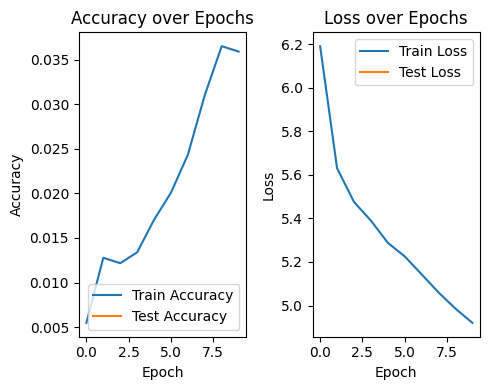

In [6]:
import matplotlib.pyplot as plt

train_acc = train_result.metrics.extra["accuracy_history"]
train_loss = train_result.metrics.extra["loss_history"]
test_acc = test_result.accuracy
test_loss = test_result.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### MIA Attacks on Identifier Model 

In [8]:
from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(CelebAHQInputHandler, config_path)

# Run the audit 
mia_results = leakpro.run_audit(create_pdf=True)

2025-04-23 22:44:52,164 INFO     Target model blueprint created from ResNet18 in ./utils/celeb_hq_model.py.
04/23/2025 22:44:52:INFO:Target model blueprint created from ResNet18 in ./utils/celeb_hq_model.py.
2025-04-23 22:44:52,175 INFO     Loaded target model metadata from ./target/model_metadata.pkl
04/23/2025 22:44:52:INFO:Loaded target model metadata from ./target/model_metadata.pkl


2025-04-23 22:44:52,710 INFO     Loaded target model from ./target
04/23/2025 22:44:52:INFO:Loaded target model from ./target
2025-04-23 22:44:57,739 INFO     Loaded population dataset from ./data/celeba_hq_data.pkl
04/23/2025 22:44:57:INFO:Loaded population dataset from ./data/celeba_hq_data.pkl
2025-04-23 22:44:57,744 INFO     Image extension initialized.
04/23/2025 22:44:57:INFO:Image extension initialized.
2025-04-23 22:44:57,746 INFO     MIA attack factory loaded.
04/23/2025 22:44:57:INFO:MIA attack factory loaded.
2025-04-23 22:44:57,750 INFO     Shadow model handler singleton already exists, updating state
04/23/2025 22:44:57:INFO:Shadow model handler singleton already exists, updating state
2025-04-23 22:44:57,879 INFO     Distillation model handler singleton already exists, updating state
04/23/2025 22:44:57:INFO:Distillation model handler singleton already exists, updating state
2025-04-23 22:44:58,141 INFO     Added attack: lira
04/23/2025 22:44:58:INFO:Added attack: lira
20

<Figure size 640x480 with 0 Axes>